In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch

from Bio.Seq import Seq
from sklearn.linear_model import HuberRegressor

from dnsmex.ablang_wrapper import AbLangWrapper
from dnsmex.local import localify
from netam import molevol
from netam import pretrained
from netam.codon_table import single_mutant_aa_indices, make_codon_neighbor_indicator
from netam.framework import trimmed_shm_model_outputs_of_crepe, load_crepe
from netam.sequences import AA_STR_SORTED
from netam.sequences import nt_idx_tensor_of_str, translate_sequences

from netam.common import heavy_chain_shim

figures_dir = localify("FIGURES_DIR")

## Data prep

In [2]:
def check_six_frames(seq_str):
    """
    Perform six-frame translation of a DNA sequence and check each frame for stop codons.
    
    Args:
        seq_str (str): Input DNA sequence
        
    Returns:
        dict: Dictionary with frame number as key and tuple of (has_stop_codon, translated_sequence) as value
    """
    seq = Seq(seq_str.upper())
    frames = {}
    
    # Forward frames (1, 2, 3)
    for i in range(3):
        frame = seq[i:]
        translated = frame.translate()
        has_stop = '*' in translated[:-1]  # Ignore stop codon at the end
        frames[f"+{i+1}"] = (has_stop, str(translated))
    
    # Reverse frames (-1, -2, -3)
    rev_seq = seq.reverse_complement()
    for i in range(3):
        frame = rev_seq[i:]
        translated = frame.translate()
        has_stop = '*' in translated[:-1]  # Ignore stop codon at the end
        frames[f"-{i+1}"] = (has_stop, str(translated))
    
    return frames

def find_open_frames(seq_str):
    """
    Find reading frames without internal stop codons.
    
    Args:
        seq_str (str): Input DNA sequence
        
    Returns:
        list: List of frame numbers that don't contain internal stop codons
    """
    frames = check_six_frames(seq_str)
    open_frames = [frame for frame, (has_stop, _) in frames.items() if not has_stop]
    return open_frames

def find_open_frame(seq_str):
    """
    Find the first reading frame without internal stop codons.
    
    Args:
        seq_str (str): Input DNA sequence
        
    Returns:
        str: Frame number that doesn't contain internal stop codons
    """
    frames = check_six_frames(seq_str)
    open_frame = next(frame for frame, (has_stop, _) in frames.items() if not has_stop)
    return open_frame

In [3]:
path = localify("DATA_DIR/loris/rodriguez-igm/W-117_PRCONS-IGM_igblast.tsv")

# read tsv from path
airr_df = pd.read_csv(path, sep='\t')

# subset the rows of airr_df keeping those with "stop_codon" == False and "vj_in_frame" == True
airr_df = airr_df.query('stop_codon == "F" and vj_in_frame == "T"')

airr_df["open_frame_count"] = [len(find_open_frames(seq)) for seq in airr_df["sequence"]]
airr_df = airr_df.query("open_frame_count == 1").copy()

/Users/matsen/re/netam/.venv/lib/python3.11/site-packages/Bio/Seq.py:2879: BiopythonWarning: Partial codon, len(sequence) not a multiple of three. Explicitly trim the sequence or add trailing N before translation. This may become an error in future.
  warnings.warn(


In [4]:
def trim_row(row):
    """
    Trim a sequence based on v_sequence_start and j_sequence_end, ensuring codon alignment.
    
    Args:
        row: DataFrame row with 'sequence', 'v_sequence_start' (1-indexed), and 'j_sequence_end' (1-indexed)
    
    Returns:
        str: Trimmed sequence that is codon-aligned
    """
    seq = row["sequence"]
    v_start = row["v_sequence_start"] - 1  # Convert to 0-based
    j_end = int(row["j_sequence_end"])  # Don't subtract 1 since we'll use it as slice end
    
    # Get initial trimmed sequence
    trimmed = seq[v_start:j_end]
    
    # Calculate how many bases to remove to make it divisible by 3
    remainder = len(trimmed) % 3
    if remainder > 0:
        # Remove remainder bases from the end
        trimmed = trimmed[:(len(trimmed) - remainder)]
    
    return trimmed

# Apply the function to create trimmed_sequence column
airr_df["trimmed_sequence"] = airr_df.apply(trim_row, axis=1)

In [5]:
airr_df["aa_sequence"] = [str(Seq(seq).translate()) for seq in airr_df["trimmed_sequence"]]
# remove any rows where the aa_sequence contains a stop codon or an X
airr_df = airr_df[~airr_df["aa_sequence"].str.contains("\*|X")]
airr_df.reset_index(drop=True, inplace=True)
airr_df["aa_sequence"]

0      QVQLQQWGAGLLKPSETLSLTCAVYGGSFSGYYWSWIRQPPGKGLE...
1      QVQLQESGPGLVKPSQTLSLTCTVSGGSISSGDYYWSWIRQPPGKG...
2      EVQLVQSGAEVKKPGATVKISCKVSGYTFTDYYMHWVQQAPGKGLE...
3      QVQLQESGPGLVKPSETLSLTCVVSGYSISNGYYWGWIRQPPGKGL...
4      QLQLQESGPGLVKPSETLSLTCTVSGGSISSSSYYWGWIRQPPGKG...
                             ...                        
244    QVQLQESGPGLVKPSQTLSLTCTVSGGSISSGDYYWSWIRQPPGKG...
245    EVQLVQSGAEVKKPGESLRISCKGSGYSFTTYWISWVRQMPGKGLE...
246    QVQLQESGPGLVKPSETLSLTCAVSGYSISSGYYWGWIRQPPGKGL...
247    EVQLLESGGGLVQPGGSLRLSCAASGFTFSSYAMSWVRQAPGKGLE...
248    QVQLVESGGGLVKPGGSLRLSCAASGFTFSDYYMSWIRQAPGKGLE...
Name: aa_sequence, Length: 249, dtype: object

## Analysis of a single naive sequence

In [6]:
seq = airr_df["aa_sequence"][0]

ablang_wrapper = AbLangWrapper(aa_order=list(AA_STR_SORTED))
logits = ablang_wrapper.masked_logits(seq, "").numpy()
seq, len(seq), logits.shape

/Users/matsen/re/netam/.venv/lib/python3.11/site-packages/ablang2/load_model.py:112: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(


('QVQLQQWGAGLLKPSETLSLTCAVYGGSFSGYYWSWIRQPPGKGLEWIGEINHSGSTNYNPSLKSRVTISVDTSKNQFSLKLSSVTAADTAVYYCARESPVLRFLEWLPSHWYFDLWGRGTLVTVSS',
 127,
 (20, 127))

In [7]:
max_indices = np.argmax(logits, axis=0)

max_indices

ml_seq = "".join([AA_STR_SORTED[i] for i in max_indices])
print(seq)
print(ml_seq)

QVQLQQWGAGLLKPSETLSLTCAVYGGSFSGYYWSWIRQPPGKGLEWIGEINHSGSTNYNPSLKSRVTISVDTSKNQFSLKLSSVTAADTAVYYCARESPVLRFLEWLPSHWYFDLWGRGTLVTVSS
QVQLQQWGAGLLKPSETLSLTCAVYGGSFSGYYWSWIRQPPGKGLEWIGEINHSGSTNYNPSLKSRVTISVDTSKNQFSLKLSSVTAADTAVYYCARGRRVLRFLEWLLRYWYFDLWGRGTLVTVSS


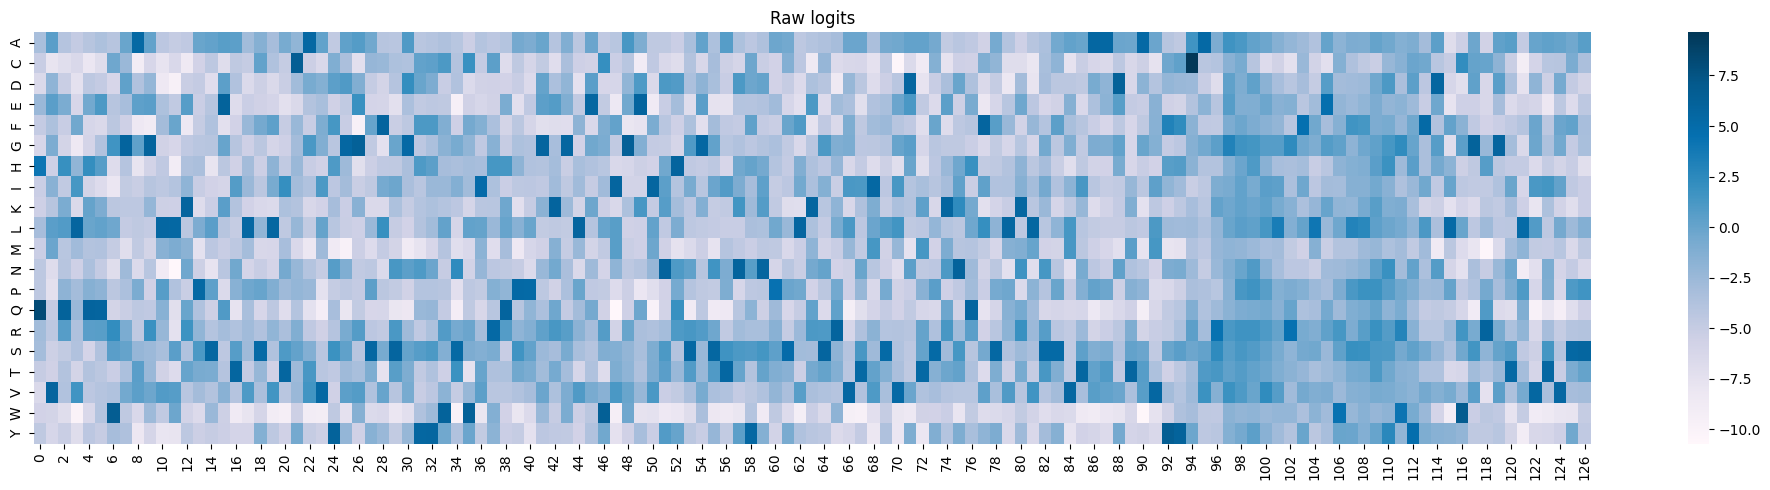

In [8]:
def plot_heatmap(logits, title=None, neighbor=None):
    """Plot a heatmap with optional dot markers for neighbors.
    
    Args:
        logits (ndarray): 2D array of likelihood values.
        title (str, optional): Title of the plot.
        neighbor (ndarray, optional): Binary array of the same shape as `logits`.
                                      If provided, dots will be added to mark `True` cells.
    """
    plt.figure(figsize=(20, 5))
    
    # Create a mask for NaNs
    mask = np.isnan(logits)

    # Create a colormap with gray for NaNs
    cmap = sns.color_palette("PuBu", as_cmap=True)
    cmap.set_bad(color='yellow')  # Set color for NaNs

    # Plot heatmap with mask and custom colormap
    sns.heatmap(logits, mask=mask, cmap=cmap)

    # Set y-ticks to be centered on each cell
    plt.gca().set_yticks(np.arange(logits.shape[0]) + 0.5)
    plt.gca().set_yticklabels(list(AA_STR_SORTED))

    # Add dot markers if `neighbor` is provided
    if neighbor is not None:
        # Find the (row, col) coordinates where neighbor is True
        row_indices, col_indices = np.where(neighbor)
        
        # Scatter dots at the center of those cells
        plt.scatter(
            col_indices + 0.5,  # Shift by 0.5 to center in the cell
            row_indices + 0.5,  # Shift by 0.5 to center in the cell
            color='red',        # Dot color
            s=0.5               # Dot size
        )

    if title:
        plt.title(title)
    plt.tight_layout()
    plt.show()

plot_heatmap(logits, title="Raw logits")

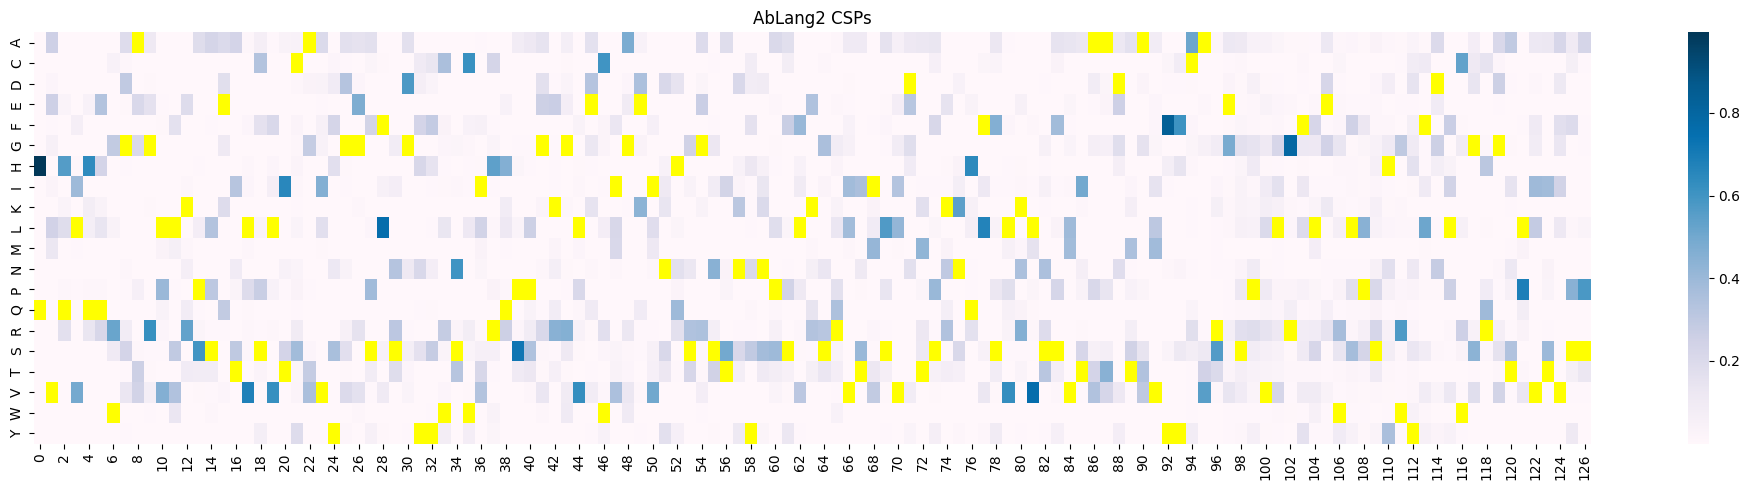

In [9]:
# get the index of every entry of seq in AA_STR_SORTED
seq_indices = [AA_STR_SORTED.index(aa) for aa in seq]
# copy likelihoods to csps
csps = logits.copy()
# set entries of seq_indices in likelihoods to -1e9
csps[seq_indices, np.arange(len(seq_indices))] = -1e9
# do softmax for each column of csps
csps = np.exp(csps) / np.exp(csps).sum(axis=0)
csps[seq_indices, np.arange(len(seq_indices))] = np.nan
# plot the heatmap of csps
plot_heatmap(csps, title="AbLang2 CSPs")

In [10]:
[AA_STR_SORTED[idx] for idx in single_mutant_aa_indices("CAG")]

['E', 'H', 'K', 'L', 'P', 'Q', 'R']

## Neighbor analysis

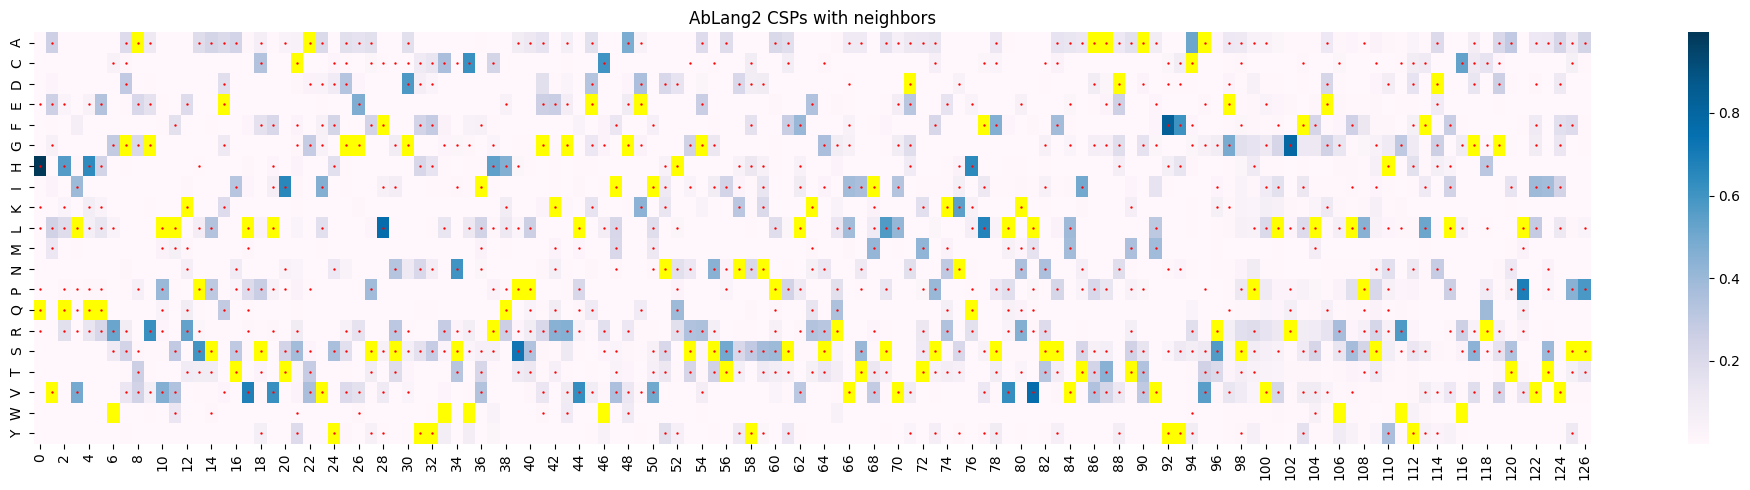

In [11]:
nt_seq = airr_df["trimmed_sequence"][0]

neighbor = make_codon_neighbor_indicator(nt_seq)

plot_heatmap(csps, title="AbLang2 CSPs with neighbors", neighbor=neighbor)

In [12]:
crepe = load_crepe(localify("DASM_TRAINED_MODELS_DIR/dasm_4m-v1tangCC+v1vanwinkleheavyTrainCC+v1jaffePairedCC+v1vanwinklelightTrainCC1m-joint"))
neutral_crepe = pretrained.load(crepe.model.hyperparameters["neutral_model_name"])
crepe = heavy_chain_shim(crepe)
[sel_factors] = crepe([seq])
sel_factors = sel_factors.numpy().T

Loading model ThriftyHumV0.2-59
Using cached models: /Users/matsen/re/netam/netam/_pretrained/thrifty-0.2.0.zip


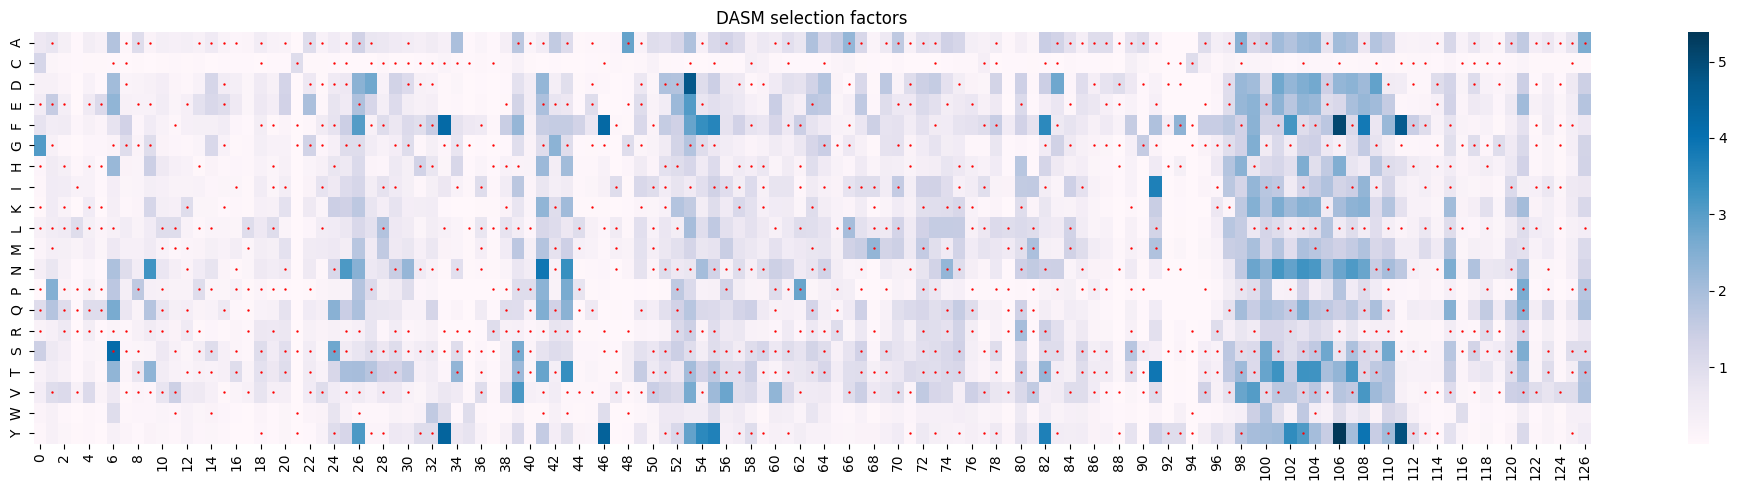

In [13]:
plot_heatmap(sel_factors, title="DASM selection factors", neighbor=neighbor)

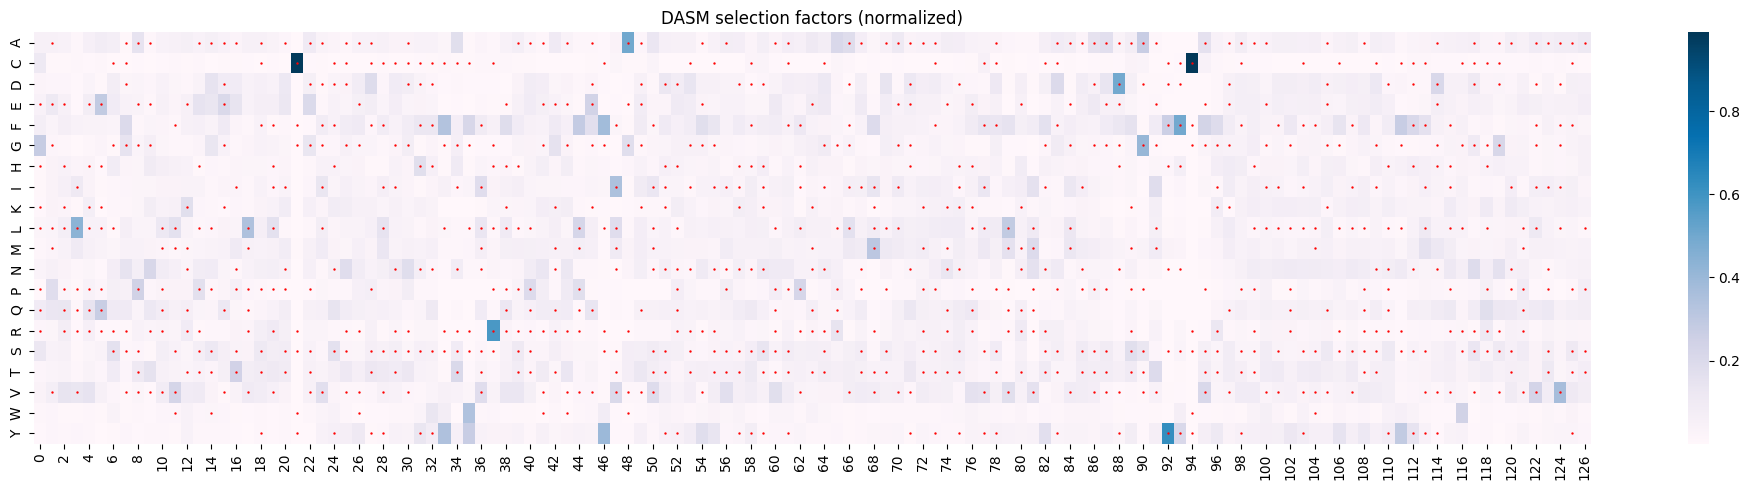

In [14]:
# set normed_sel_factors to be the probability-normalized selection factors calculated column per column, ignoring nas
normed_sel_factors = sel_factors / np.nansum(sel_factors, axis=0)
plot_heatmap(normed_sel_factors, title="DASM selection factors (normalized)", neighbor=neighbor)

In [15]:
def plot_neighbor_distribution(csps, neighbor, y_name):
    """Create a scatter plot comparing CSP distributions between Neighbor codons and 
    non-neighbors using a colorblind-safe palette.

    Args:
        csps (ndarray): 2D array with CSP values
        neighbor (ndarray): 2D binary array indicating neighbor state
        y_name (str): Label prefix for the y-axis
    """
    neighbor_name="single"
    non_neighbor_name="multiple"

    # Mask NaNs and flatten arrays
    mask = ~np.isnan(csps)
    csps_flat = csps[mask]
    neighbor_flat = neighbor[mask]
    
    # Create DataFrame with ordered categories
    categories = pd.CategoricalDtype([neighbor_name, non_neighbor_name], ordered=True)
    data = pd.DataFrame({
        'CSP': csps_flat,
        'Type': pd.Series(neighbor_flat).map({
            False: non_neighbor_name,
            True: neighbor_name
        }).astype(categories)
    })
    
    n_neighbors = neighbor_flat.sum()
    n_non_neighbors = (~neighbor_flat).sum()
    neighbor_alpha = min(1, 200 / n_neighbors)
    non_neighbor_alpha = min(1, 200 / n_non_neighbors)
    
    fig, ax = plt.subplots(figsize=(3.72, 4))
    
    colors = {neighbor_name: '#1f78b4', non_neighbor_name: '#33a02c'}
    
    for category, alpha in [(neighbor_name, neighbor_alpha), 
                            (non_neighbor_name, non_neighbor_alpha)]:
        category_data = data[data['Type'] == category]
        
        x_pos = 0 if category == neighbor_name else 1
        x_jitter = np.random.normal(0, 0.085, size=len(category_data))
        
        ax.scatter(x_pos + x_jitter, category_data['CSP'],
                   alpha=alpha, color=colors[category], s=10, linewidths=0)
    
    for x_pos, category in enumerate([neighbor_name, non_neighbor_name]):
        median = data[data['Type'] == category]['CSP'].median()
        ax.hlines(median, x_pos - 0.25, x_pos + 0.25, 
                  colors='red', linestyles='--', linewidths=1.75)
    
    ax.set_ylabel(f"{y_name} of alternative amino acid")
    ax.set_xlabel("Nucleotide mutations to reach AA", labelpad=10)
    ax.set_xticks([0, 1])
    ax.set_xticklabels([neighbor_name, non_neighbor_name])
    
    ax.set_yscale('log')
    
    sns.despine(ax=ax)
    plt.tight_layout()
    
    return fig, ax

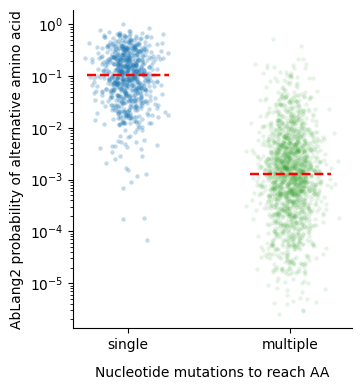

In [16]:
fig, _ = plot_neighbor_distribution(csps, neighbor, y_name="AbLang2 probability")
fig.savefig(figures_dir + "/ablang2-neighbor-csp.svg", bbox_inches='tight', pad_inches=0)

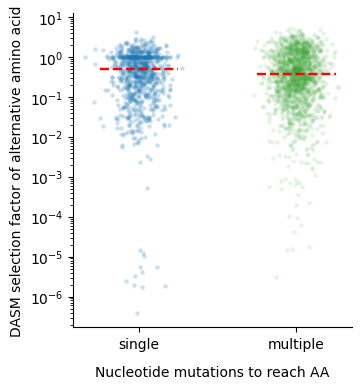

In [17]:
fig, _ = plot_neighbor_distribution(sel_factors, neighbor, y_name="DASM selection factor")
fig.savefig(figures_dir + "/dasm-neighbor-csp.svg", bbox_inches='tight', pad_inches=0)

## Mutability analysis

First calculate the probability of nonsynonymous mutations from the nucleotide sequence.

In [18]:
nt_seqs = airr_df["trimmed_sequence"][:9]
aa_seqs = translate_sequences(nt_seqs)


def log_neutral_aa_mut_probs_of(nt_seq): 
    nt_idx_tensor = nt_idx_tensor_of_str(nt_seq)

    ([nt_rates], [nt_csps]) = trimmed_shm_model_outputs_of_crepe(neutral_crepe, [nt_seq])

    branch_length = 0.1
    mut_probs = 1.0 - torch.exp(-branch_length * nt_rates)

    neutral_aa_mut_probs = molevol.neutral_aa_mut_probs(
        nt_idx_tensor.reshape(-1, 3),
        mut_probs.reshape(-1, 3),
        nt_csps.reshape(-1, 3, 4),
    )

    return (torch.log(neutral_aa_mut_probs)).numpy()

log_neutral_aa_mut_probss = [log_neutral_aa_mut_probs_of(nt_seq) for nt_seq in nt_seqs]

Now calculate the probability of the naive amino acid at each position according to AbLang.

In [19]:
def ablang_wt_logits_of(seq):
    logits = ablang_wrapper.masked_logits(seq, "").numpy()
    normed_logits = np.log(np.exp(logits) / np.exp(logits).sum(axis=0))
    aa_indices = [AA_STR_SORTED.index(aa) for aa in seq]
    return normed_logits[aa_indices, np.arange(len(aa_indices))]

ablang_wt_logitss = [ablang_wt_logits_of(seq) for seq in aa_seqs]

Let's trim to the first 90 codons to only look at the V region. The CDR3 gets a bit messy.

In [20]:
v_lengths = [90 for _ in aa_seqs]

trimmed_log_neutral_probss = [probs[:length] for probs, length in zip(log_neutral_aa_mut_probss, v_lengths)]
trimmed_ablang_wt_logitss = [logits[:length] for logits, length in zip(ablang_wt_logitss, v_lengths)]

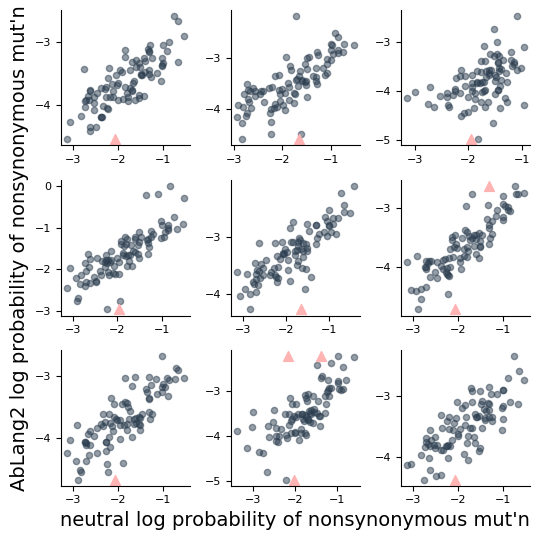


Correlation Analysis Summary:
   slope  r_squared  p_value  sample_size
0  0.502      0.628      0.0           89
1  0.562      0.564      0.0           89
2  0.436      0.218      0.0           89
3  0.716      0.667      0.0           89
4  0.548      0.699      0.0           89
5  0.634      0.748      0.0           88
6  0.559      0.654      0.0           89
7  0.690      0.564      0.0           87
8  0.525      0.586      0.0           89


In [21]:
def find_outliers_from_robust_regression(x, y, residual_threshold=7.0):
    X = x.reshape(-1, 1)
    reg = HuberRegressor()
    reg.fit(X, y)
    
    y_pred = reg.predict(X)
    residuals = y - y_pred
    mad = np.median(np.abs(residuals - np.median(residuals)))
    outliers = np.abs(residuals) > (residual_threshold * mad)
    
    return outliers
from scipy import stats
import pandas as pd

def analyze_correlation(x, y, outliers):
    # Remove outliers and perform linear regression
    x_clean = x[~outliers]
    y_clean = y[~outliers]
    
    slope, intercept, r_value, p_value, std_err = stats.linregress(x_clean, y_clean)
    r_squared = r_value**2
    
    return {
        'slope': slope,
        'r_squared': r_squared,
        'p_value': p_value,
        'sample_size': len(x_clean)
    }

# Modify the plotting code to collect statistics
fig, axes = plt.subplots(3, 3, figsize=(5.5, 5.5))
axes = axes.flat

# List to collect results
correlation_results = []

for i, (neutral_probs, ablang_logits) in enumerate(zip(trimmed_log_neutral_probss, trimmed_ablang_wt_logitss)):
    ax = axes[i]
    ablang_prob_nonsyn = np.log(1.0 - np.exp(ablang_logits))
    outliers = find_outliers_from_robust_regression(neutral_probs, ablang_prob_nonsyn)
    
    # Collect statistics
    stats_dict = analyze_correlation(neutral_probs, ablang_prob_nonsyn, outliers)
    correlation_results.append(stats_dict)
    
    # Main points
    ax.scatter(neutral_probs[~outliers], ablang_prob_nonsyn[~outliers], 
              alpha=0.5, s=20, color='#2c3e50')
    
    # Outliers 
    if outliers.any():
        x_clean = neutral_probs[~outliers]
        y_clean = ablang_prob_nonsyn[~outliers]
        x_clipped = np.clip(neutral_probs[outliers], x_clean.min(), x_clean.max())
        y_clipped = np.clip(ablang_prob_nonsyn[outliers], y_clean.min(), y_clean.max())
        ax.scatter(x_clipped, y_clipped, s=50, color='#ffb3b3', marker='^')
    
    # Set integer ticks
    x_min, x_max = ax.get_xlim()
    y_min, y_max = ax.get_ylim()
    ax.set_xticks(np.arange(int(np.ceil(x_min)), int(np.floor(x_max)) + 1))
    ax.set_yticks(np.arange(int(np.ceil(y_min)), int(np.floor(y_max)) + 1))
    
    ax.spines[['top', 'right']].set_visible(False)
    ax.tick_params(labelsize=8)

axes[3].set_ylabel('AbLang2 log probability of nonsynonymous mut\'n', size=14)
axes[7].set_xlabel('neutral log probability of nonsynonymous mut\'n', size=14)
plt.tight_layout()
plt.show()
fig.savefig(figures_dir + "/ablang2-vs-neutral.svg")

# Create a summary DataFrame
results_df = pd.DataFrame(correlation_results)
print("\nCorrelation Analysis Summary:")
print(results_df.round(3))